In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import sklearn
import random
from unicodedata import normalize
from keras.layers import Dense
from keras import Input
import librosa.display
from keras_preprocessing.sequence import pad_sequences 
import tensorflow as tf

2022-09-17 14:52:01.992713: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-17 14:52:02.240608: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-17 14:52:03.158544: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-09-17 14:52:03.158657: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

In [2]:
# 오디오 데이터
DATA_DIR_TRAIN = './real_check/train/'
DATA_DIR_TEST = './real_check/test/'

In [3]:
# Data set list, include (raw data, mfcc data, y data)
trainset = []
testset = []

# split each set into raw data, mfcc data, and y data
# STFT 한 것, CNN 분석하기 위해 Spectogram으로 만든 것, MF한 것, mel0spectogram 한 것
train_X = []
train_mfccs = []
train_y = []

test_X = []
test_mfccs = []
test_y = []

# 모든 음성파일의 길이가 같도록 후위에 padding 처리
pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i-a.shape[0])))
pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))

frame_length = 0.025
frame_stride = 0.0010

In [4]:
# train data를 넣는다.
for filename in os.listdir(DATA_DIR_TRAIN):
    filename = normalize('NFC', filename)
    try:
    # wav 포맷 데이터만 사용
        if '.wav' not in filename in filename:
            continue
      
        wav, sr = librosa.load(DATA_DIR_TRAIN+ filename, sr=16000)
    
        mfcc = librosa.feature.mfcc(wav, sr=16000, n_mfcc=100, n_fft=400, hop_length=160)
        mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
        padded_mfcc = pad2d(mfcc, 200)

    # 추임새 별로 dataset에 추가
    # 응/아니
        if filename[0] == '응':
            trainset.append((padded_mfcc, 0))
        elif filename[0] == '아':
            trainset.append((padded_mfcc, 1))
    except Exception as e:
        print(filename, e)
        raise

# 학습 데이터를 무작위로 섞는다.
random.shuffle(trainset)

/home/jupyter-j7d210/.local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/jupyter-j7d210/.local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/jupyter-j7d210/.local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/jupyter-j7d210/.local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and m

In [5]:
# test data를 넣는다.
for filename in os.listdir(DATA_DIR_TEST):
    filename = normalize('NFC', filename)
    try:
    # wav 포맷 데이터만 사용
        if '.wav' not in filename in filename:
            continue
      
        wav, sr = librosa.load(DATA_DIR_TEST+ filename, sr=16000)
    
        mfcc = librosa.feature.mfcc(wav, sr=16000, n_mfcc=100, n_fft=400, hop_length=160)
        mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
        padded_mfcc = pad2d(mfcc, 200)

    # 추임새 별로 dataset에 추가
    # 응/아니
        if filename[0] == '응':
            testset.append((padded_mfcc, 0))
        elif filename[0] == '아':
            testset.append((padded_mfcc, 1))
    except Exception as e:
        print(filename, e)
        raise

# 평가 데이터를 무작위로 섞는다.
random.shuffle(testset)

/home/jupyter-j7d210/.local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/jupyter-j7d210/.local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/jupyter-j7d210/.local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/jupyter-j7d210/.local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and m

In [6]:
train_mfccs = [a for (a,b) in trainset]
train_y = [b for (a,b) in trainset]

test_mfccs = [a for (a,b) in testset]
test_y = [b for (a,b) in testset]

train_mfccs = np.array(train_mfccs)
train_y = tf.keras.utils.to_categorical(np.array(train_y))

test_mfccs = np.array(test_mfccs)
test_y = tf.keras.utils.to_categorical(np.array(test_y))

print('train_mfccs:', train_mfccs.shape)
print('train_y:', train_y.shape)

print('test_mfccs:', test_mfccs.shape)
print('test_y:', test_y.shape)

train_mfccs: (600, 100, 200)
train_y: (600, 2)
test_mfccs: (100, 100, 200)
test_y: (100, 2)


In [7]:
train_X_ex = np.expand_dims(train_mfccs, -1)
test_X_ex = np.expand_dims(test_mfccs, -1)
print('train X shape:', train_X_ex.shape)
print('test X shape:', test_X_ex.shape)

train X shape: (600, 100, 200, 1)
test X shape: (100, 100, 200, 1)


In [8]:
ip = Input(shape=train_X_ex[0].shape)

m = tf.keras.layers.Conv2D(32, kernel_size=(4,4), activation='relu')(ip)
m = tf.keras.layers.MaxPooling2D(pool_size=(4,4))(m)

m = tf.keras.layers.Conv2D(32*2, kernel_size=(4,4), activation='relu')(ip)
m = tf.keras.layers.MaxPooling2D(pool_size=(4,4))(m)

m = tf.keras.layers.Conv2D(32*3, kernel_size=(4,4), activation='relu')(ip)
m = tf.keras.layers.MaxPooling2D(pool_size=(4,4))(m)

m = tf.keras.layers.Flatten()(m)

m = Dense(64, activation='relu')(m)

m = Dense(32, activation='relu')(m)

op = Dense(2, activation='softmax')(m)

model = tf.keras.Model(ip, op)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 200, 1)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 97, 197, 96)       1632      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 49, 96)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 112896)            0         
                                                                 
 dense (Dense)               (None, 64)                7225408   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                             

2022-09-17 14:52:51.768412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 14:52:51.769147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 14:52:51.769719: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 14:52:51.770282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 14:52:51.770841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_X_ex,
                    train_y,
                    epochs=20,
                    verbose=1,
                    validation_data=(test_X_ex, test_y))

Epoch 1/20
19/19 [==============================] - 4s 174ms/step - loss: 1.2771 - accuracy: 0.5300 - val_loss: 0.6769 - val_accuracy: 0.5100
Epoch 2/20
19/19 [==============================] - 3s 162ms/step - loss: 0.6501 - accuracy: 0.6683 - val_loss: 0.7468 - val_accuracy: 0.5000
Epoch 3/20
19/19 [==============================] - 3s 182ms/step - loss: 0.5739 - accuracy: 0.7267 - val_loss: 0.6119 - val_accuracy: 0.6600
Epoch 4/20
19/19 [==============================] - 3s 131ms/step - loss: 0.4615 - accuracy: 0.7850 - val_loss: 0.8425 - val_accuracy: 0.5200
Epoch 5/20
19/19 [==============================] - 3s 145ms/step - loss: 0.4181 - accuracy: 0.7883 - val_loss: 0.5338 - val_accuracy: 0.7400
Epoch 6/20
19/19 [==============================] - 3s 185ms/step - loss: 0.3678 - accuracy: 0.8267 - val_loss: 0.6079 - val_accuracy: 0.6400
Epoch 7/20
19/19 [==============================] - 4s 189ms/step - loss: 0.3091 - accuracy: 0.8550 - val_loss: 0.7512 - val_accuracy: 0.7100
Epoch 

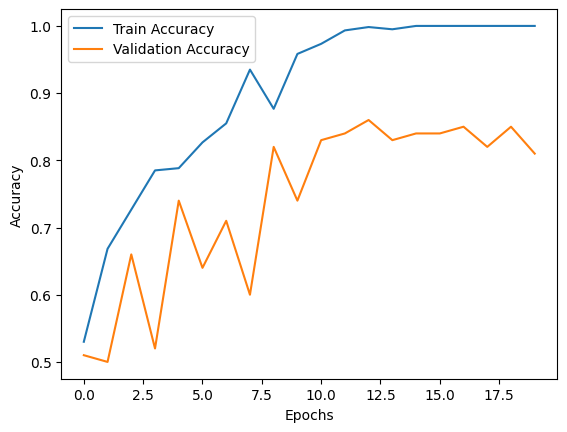

In [10]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [36]:
# 샘플 오디오 데이터
DATA_DIR = './sample_check/'

wav, sr = librosa.load(DATA_DIR + 'sample_8(아니).wav', sr=16000)
print('sr:', sr)
print('wav shape:', wav.shape)
print('length:', wav.shape[0]/float(sr), 'secs')

sr: 16000
wav shape: (43691,)
length: 2.7306875 secs


In [37]:
mfcc = librosa.feature.mfcc(wav, sr=16000, n_mfcc=100, n_fft=400, hop_length=160)
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
padded_mfcc = pad2d(mfcc, 200)
padded_mfcc = np.expand_dims(padded_mfcc, 0)

result = model.predict(padded_mfcc)
print(result)
if result[0][0] > result[0][1]: # 응
    print('응') 
else:
    print('아니')

1/1 [==============================] - 0s 51ms/step
[[0.83849126 0.16150871]]
응


/home/jupyter-j7d210/.local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/jupyter-j7d210/.local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


In [13]:
model.save('/content/drive/My Drive/졸프/0726Data/filler_determine_model_by_train2_1205.h5')

PermissionDeniedError: /content; Permission denied